<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%ED%9D%91%EB%B0%B1%EC%82%AC%EC%A7%84%EC%9D%84%20%EC%BB%AC%EB%9F%AC%EC%82%AC%EC%A7%84%EC%9C%BC%EB%A1%9C%20%EB%B0%94%EA%BE%B8%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/MyDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g71BS2CFpu3u2roaTlFf5jW0CgCBShffm-ZD8-jZCBsRYpBaD1QX6U
Mounted at /content/MyDrive


In [3]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')

In [4]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

## Preprocessing

In [6]:
print(train_images.shape)
print(test_images.shape)

(1700, 100, 75, 3)
(300, 100, 75, 3)


In [9]:
(train_images[train_images != 0])

array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
       0.01470588])

In [12]:
print(train_images.min(), train_images.max())
print(test_images.min(), test_images.max())

0.0 1.0
0.0 1.0


In [16]:
train_images.shape

(1700, 100, 75, 3)

In [25]:
# 흑백이미지 생성
from skimage.color import rgb2gray
train_gray_images = rgb2gray(train_images)
test_gray_images = rgb2gray(test_images)

In [33]:
print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75) (300, 100, 75)


In [40]:
train_gray_images = train_gray_images.reshape((1700,100,75,1))
test_gray_images = test_gray_images.reshape((300,100,75,1))

In [41]:
print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


## Visualizing

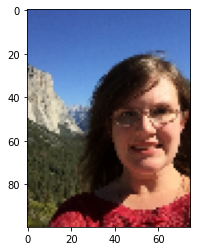

In [46]:
plt.imshow(train_images[0])

(5, 100, 75, 3)
(100, 375, 3)


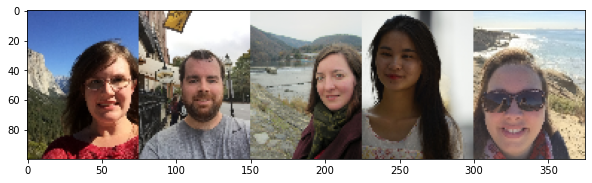

In [50]:
print(train_images[:5].shape)
print(np.hstack(train_images[:5]).shape)
plt.figure(figsize=(10,6))
plt.imshow(np.hstack(train_images[:5]))
plt.show()

(5, 100, 75, 3)
(100, 5, 75, 3)
(100, 375, 3)


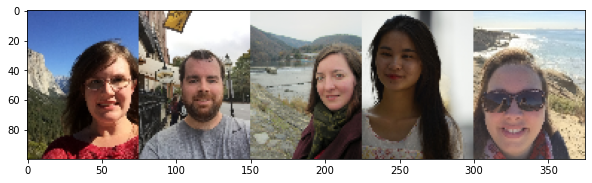

In [54]:
print(train_images[:5].shape)
print(train_images[:5].transpose(1,0,2,3).shape)
print(train_images[:5].transpose(1,0,2,3).reshape((100,-1,3)).shape)
plt.figure(figsize=(10,6))
plt.imshow(train_images[:5].transpose(1,0,2,3).reshape((100,-1,3)))
plt.show()

# Modeling

In [56]:
# Input : (100,75,1) // Output : (100,75,3)
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [87]:
def conv2d_block(x, channel) :
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_color() :
    inputs = Input((100,75,1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p1, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p1, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
     
    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=(0,1))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(1,0))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    '''
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(0,1))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation='sigmoid')(c9)
    '''
    model = Model(inputs, c7)
    return model


In [88]:
model = unet_color()
model.summary(
)

ValueError: ignored

# Preprocessing

# Preprocessing

# Preprocessing

# Preprocessing